In [7]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import shape
import os
import sys
os.chdir('/home/vaschetti/maxarSrc/src')
from maxarseg.geoDatasets import Maxar
from maxarseg.samplers import MyGridGeoSampler
from torch.utils.data import DataLoader
from torchgeo.datasets import stack_samples, unbind_samples
from maxarseg.samplers_utils import boundingBox_2_Polygon
import numpy as np
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import cv2
import supervision as sv
import torch
from maxarseg.segment import building_gdf, rel_bbox_coords, rel_polyg_coord
from random import randint

Initialize FastSAM

In [2]:
sys.path.append('/home/vaschetti/maxarSrc/models')
from FastSAM.fastsam import FastSAM, FastSAMPrompt
from FastSAM.utils.tools import convert_box_xywh_to_xyxy

In [3]:
model_path = '/home/vaschetti/maxarSrc/models/FastSAM/weights/FastSAM-x.pt'
model = FastSAM(model_path)

Creazione del dataset delle immagini

In [4]:
dataset = Maxar('/mnt/data2/vaschetti_data/maxar/Gambia-flooding-8-11-2022/pre/10300100CFC9A500/033133031213.tif')
size = 608
sampler = MyGridGeoSampler(dataset, size=size, stride=size)
dataloader = DataLoader(dataset, sampler=sampler, collate_fn=stack_samples)
data_crs = dataset.crs

Creazione dataset degli edifici

In [5]:
gdfs_32628 = building_gdf('TheGambia', '/home/vaschetti/maxarSrc/metadata/buildings_dataset_links.csv' ,dataset_crs = data_crs)
index_MS_buildings = gdfs_32628.sindex

Found 6 links for TheGambia


Iterate over the dataloader

In sampler
tile_polygon:  POLYGON ((320156.25 1489843.75, 315455.322265625 1489843.75, 315470.63516642543 1492342.8892077415, 320156.25 1491748.5059546148, 320156.25 1489843.75))
In plot
Crs EPSG:32628
sx_low:  (317441.40625, 1489843.75)
dx_high:  (317626.953125, 1490029.296875)


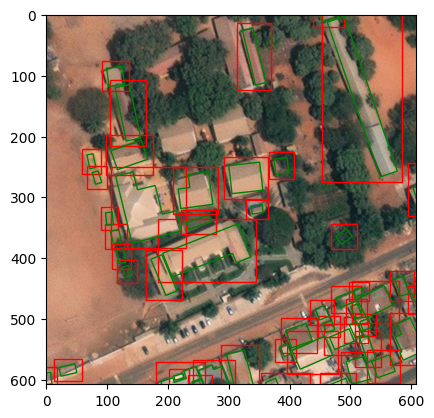

In [10]:
dataset_res = dataset.res
i = 0
for batch in dataloader:
    query_bbox_poly = boundingBox_2_Polygon(batch['bbox'][0])
    hits = index_MS_buildings.query(query_bbox_poly)
    if len(hits) > 10: #per prendere immagini con almeno X edifici
        i+=1
        if i == 7:#randint(0, 20): #per prendere immagini random
            sample = unbind_samples(batch)[0]
            img4Sam = sample["image"].permute(1, 2, 0).numpy().astype('uint8')
            
            #predictor.set_image(img4Sam) #encoding the image

            #Getting the relative coordinates of the buildings boxes
            building_boxes = rel_bbox_coords(gdfs_32628.iloc[hits], query_bbox_poly.bounds, dataset_res, ext_mt=5)

            #Plotting
            fig, ax = dataset.plot(sample)   
            for box in building_boxes:
                x0, y0 = box[0], box[1]
                w, h = box[2] - box[0], box[3] - box[1]
                rect = patches.Rectangle((x0, y0), w, h, linewidth=1, edgecolor='r', facecolor='none')            
                ax.add_patch(rect)
            for rel_pol in rel_polyg_coord(gdfs_32628.iloc[hits], query_bbox_poly.bounds, dataset_res):
                poly = patches.Polygon(rel_pol, linewidth=1, edgecolor='g', facecolor='none')
                ax.add_patch(poly)

            break


Prepare data for the model

In [15]:
device = 'cuda:3'
everything_results = model(
        img4Sam,
        device= device,
        imgsz=img4Sam.shape[0],
        )


0: 608x608 77 objects, 37.7ms
Speed: 4.3ms preprocess, 37.7ms inference, 18.7ms postprocess per image at shape (1, 3, 608, 608)


In [16]:
bboxes = None
points = None
point_label = None
prompt_process = FastSAMPrompt(img4Sam, everything_results, device=device)

box_prompt = building_boxes
if box_prompt[0][2] != 0 and box_prompt[0][3] != 0:
    ann = prompt_process.box_prompt(bboxes=box_prompt)
    bboxes = box_prompt

In [17]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=75):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='y', marker='.', s=marker_size, edgecolor='white', linewidth=0.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='.', s=marker_size, edgecolor='white', linewidth=0.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='r', facecolor=(0,0,0,0), lw=0.5))


def plot_w_wo_masks(img, masks, boxes, pt_coords, pt_labels, only_pred=False, only_masks = False):
    
    if not only_pred:
        fig = plt.figure(figsize=(15, 15))
        ax1 = fig.add_subplot(1, 2, 1)
        ax1.imshow(img)

        ax2 = fig.add_subplot(1, 2, 2, sharex=ax1, sharey=ax1)
        ax2.imshow(img)
        for mask in masks:
            show_mask(mask.cpu().numpy(), ax2)
        if not only_masks:
            for box in boxes:
                show_box(box.cpu().numpy(), ax2)
            for point, label in zip(pt_coords.cpu(), pt_labels.cpu()):
                show_points(point.cpu().numpy(), label.cpu().numpy(), ax2)
        
        ax2.set_xlim([0, img.shape[1]])
        ax2.set_ylim([img.shape[0], 0])

        ax1.axis('off')
        ax2.axis('off')
    else:
        fig = plt.figure(figsize=(7, 7))
        plt.imshow(img)

        for mask in masks:
            show_mask(mask.cpu().numpy(), plt.gca())
        for box in boxes:
            show_box(box.cpu().numpy(), plt.gca())
        for point, label in zip(pt_coords.cpu(), pt_labels.cpu()):
            show_points(point.cpu().numpy(), label.cpu().numpy(), plt.gca())
        
        plt.gca().set_xlim([0, img.shape[1]])
        plt.gca().set_ylim([img.shape[0], 0])

        plt.gca().axis('off')

Predict the mask

In [18]:
def plot_w_wo_masks(img, masks, building_boxes = None):
    fig = plt.figure(figsize=(15, 15))
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.imshow(img)

    ax2 = fig.add_subplot(1, 2, 2, sharex=ax1, sharey=ax1)
    ax2.imshow(img)
    for mask in masks:
        show_mask(mask, ax2)
    if building_boxes is not None:
        for box in building_boxes:
            x0, y0 = box[0], box[1]
            w, h = box[2] - box[0], box[3] - box[1]
            rect = patches.Rectangle((x0, y0), w, h, linewidth=1, edgecolor='r', facecolor='none')            
            ax2.add_patch(rect)
    
    ax2.set_xlim([0, img.shape[1]])
    ax2.set_ylim([img.shape[0], 0])

    ax1.axis('off')
    ax2.axis('off')

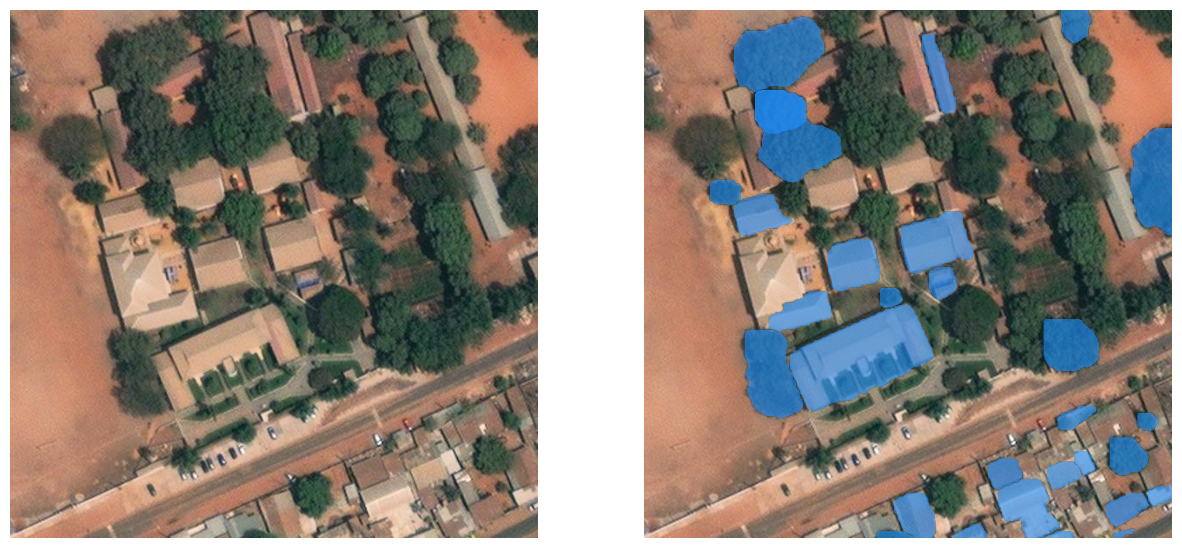

In [19]:
plot_w_wo_masks(img4Sam, ann)